In [1]:
#imports
import pandas as pd
import pyodbc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(6, 12))
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

<Figure size 432x864 with 0 Axes>

In [2]:
#conexao
def conexao_sql_server():
    server = 'LAPTOP-TA7HV3O7\SQLEXPRESS'
    database = 'olist'
    username = 'sa'
    password = 'Pazeamor10'
    string_conexao = 'Driver={SQL Server Native Client 11.0};Server='+server+';Database='+database+';UID='+username+';PWD='+password
    conexao = pyodbc.connect(string_conexao)
    return conexao

#conexao
conn = conexao_sql_server()

In [3]:
#query
query = '''
select 
    tb2.["seller_id"] as [id_vendedor],
    datediff(day, min(tb1.["order_approved_at"]), '2018-09-03') as [idade_base_dias],
    avg(cast(tb3.[review_score] as numeric)) as [avaliacao_media],
    count(distinct(tb2.["order_id"])) as [qtd_pedidos],
    count(tb2.["product_id"]) as [qtd_produtos],
    cast(count(tb2.["product_id"]) as numeric) / count(distinct(tb2.["order_id"])) as [media_produtos_por_pedido],
    sum(cast(tb2.["price"] as numeric)) as [receita_total],
    sum(cast(tb2.["price"] as numeric)) / count(distinct(tb2.["order_id"])) as  [media_valor_pedido_sem_frete],
    (sum(cast(tb2.["price"] as numeric)) + sum(cast(tb2.["freight_value"] as numeric))) / count(distinct(tb2.["order_id"])) as  [media_valor_pedido_com_frete],
    sum(cast(tb2.["freight_value"] as numeric)) / count(distinct(tb2.["order_id"])) as  [media_valor_frete],
    (convert(decimal(5,1),sum(case when tb1.["order_delivered_customer_date"] > tb1.["order_estimated_delivery_date"] then 1 else 0 end)))/count(tb2.["seller_id"]) as [prop_pedidos_atrasados],
    datediff(day, max(tb1.["order_approved_at"]), '2018-09-03') as [dias_sem_vender],
    avg(datediff(day, (tb1.["order_delivered_carrier_date"]), tb2.["shipping_limit_date"])) as [tempo_de_postagem],
    cast(count(distinct(tb2.["order_id"])) as numeric) / (datediff(day, min(tb1.["order_approved_at"]), '2018-09-03')) as [vendas_por_dia],
    count(distinct(tb2.["order_id"])) / (datediff(month, min(tb1.["order_approved_at"]), '2018-09-03')) as [vendas_por_mes]
    from olist_orders_dataset tb1

    left join olist_order_items_dataset tb2 
    on tb1.["order_id"] = tb2.["order_id"] 

    left join olist_order_reviews_dataset tb3
    on tb1.["order_id"] = tb3.[order_id]
    
    where tb1.["order_status"] = 'delivered' and tb1.["order_approved_at"] > '2017-09-03'
    group by tb2.["seller_id"]
'''   

In [4]:
#query to df
vendedores = pd.read_sql(query, conn)

In [5]:
vendedores.head()

,id_vendedor,idade_base_dias,avaliacao_media,qtd_pedidos,qtd_produtos,media_produtos_por_pedido,receita_total,media_valor_pedido_sem_frete,media_valor_pedido_com_frete,media_valor_frete,prop_pedidos_atrasados,dias_sem_vender,tempo_de_postagem,vendas_por_dia,vendas_por_mes
0,"""9c4d31c7e46ab03a43fc06e3142afd4e""",20,4.000000,2,2,1.000000,1219.0,609.500000,631.500000,22.000000,0.000000,14,2,0.100000,2
1,e3a386fc36e22064434e1fa256f6a9fa,222,4.250000,16,17,1.062500,791.0,49.437500,65.187500,15.750000,0.176471,18,2,0.072072,2
2,"""0aa2205ca24f113f4658a5c536667426""",137,5.000000,4,11,2.750000,816.0,204.000000,246.750000,42.750000,0.000000,20,6,0.029197,0
3,"""640e21a7d01df7614a3b4923e990d40c""",170,3.982758,115,136,1.182609,7529.0,65.469565,86.704347,21.234782,0.066176,9,2,0.676471,19
4,"""2156f2671501a81034d7d07f217609d0""",357,3.800000,20,20,1.000000,2861.0,143.050000,161.750000,18.700000,0.150000,38,3,0.056022,1


In [6]:
#data types
vendedores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2609 entries, 0 to 2608
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id_vendedor                   2609 non-null   object 
 1   idade_base_dias               2609 non-null   int64  
 2   avaliacao_media               2149 non-null   float64
 3   qtd_pedidos                   2609 non-null   int64  
 4   qtd_produtos                  2609 non-null   int64  
 5   media_produtos_por_pedido     2609 non-null   float64
 6   receita_total                 2609 non-null   float64
 7   media_valor_pedido_sem_frete  2609 non-null   float64
 8   media_valor_pedido_com_frete  2609 non-null   float64
 9   media_valor_frete             2609 non-null   float64
 10  prop_pedidos_atrasados        2609 non-null   float64
 11  dias_sem_vender               2609 non-null   int64  
 12  tempo_de_postagem             2609 non-null   int64  
 13  ven

In [7]:
#rounding float64 columns
float_columns = list(vendedores.select_dtypes(include='float64').columns)
vendedores[float_columns] = np.round(vendedores[float_columns], decimals = 2)

In [8]:
vendedores.head()

,id_vendedor,idade_base_dias,avaliacao_media,qtd_pedidos,qtd_produtos,media_produtos_por_pedido,receita_total,media_valor_pedido_sem_frete,media_valor_pedido_com_frete,media_valor_frete,prop_pedidos_atrasados,dias_sem_vender,tempo_de_postagem,vendas_por_dia,vendas_por_mes
0,"""9c4d31c7e46ab03a43fc06e3142afd4e""",20,4.00,2,2,1.00,1219.0,609.50,631.50,22.00,0.00,14,2,0.10,2
1,e3a386fc36e22064434e1fa256f6a9fa,222,4.25,16,17,1.06,791.0,49.44,65.19,15.75,0.18,18,2,0.07,2
2,"""0aa2205ca24f113f4658a5c536667426""",137,5.00,4,11,2.75,816.0,204.00,246.75,42.75,0.00,20,6,0.03,0
3,"""640e21a7d01df7614a3b4923e990d40c""",170,3.98,115,136,1.18,7529.0,65.47,86.70,21.23,0.07,9,2,0.68,19
4,"""2156f2671501a81034d7d07f217609d0""",357,3.80,20,20,1.00,2861.0,143.05,161.75,18.70,0.15,38,3,0.06,1


In [9]:
rfm_data = vendedores[['id_vendedor','dias_sem_vender','vendas_por_dia','receita_total']]

In [10]:
rfm_data.head()

,id_vendedor,dias_sem_vender,vendas_por_dia,receita_total
0,"""9c4d31c7e46ab03a43fc06e3142afd4e""",14,0.10,1219.0
1,e3a386fc36e22064434e1fa256f6a9fa,18,0.07,791.0
2,"""0aa2205ca24f113f4658a5c536667426""",20,0.03,816.0
3,"""640e21a7d01df7614a3b4923e990d40c""",9,0.68,7529.0
4,"""2156f2671501a81034d7d07f217609d0""",38,0.06,2861.0


In [11]:
rfm_data.isnull().sum()

id_vendedor        0
dias_sem_vender    0
vendas_por_dia     0
receita_total      0
dtype: int64

<AxesSubplot:xlabel='dias_sem_vender'>

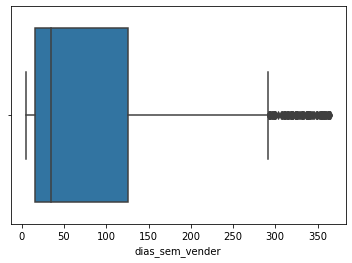

In [12]:
sns.boxplot(x=rfm_data['dias_sem_vender'])

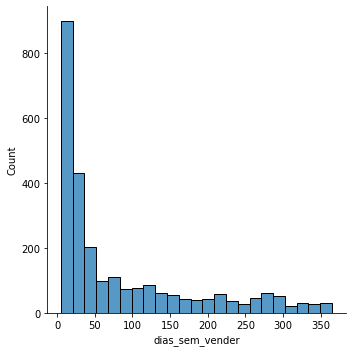

In [13]:
sns.displot(rfm_data['dias_sem_vender'])

<AxesSubplot:xlabel='vendas_por_dia'>

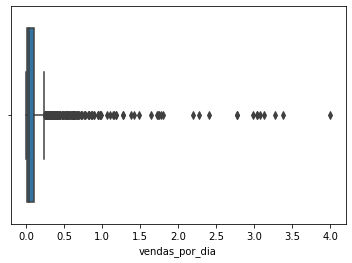

In [14]:
sns.boxplot(x=rfm_data['vendas_por_dia'])

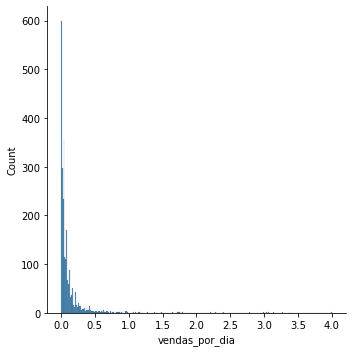

In [15]:
sns.displot(rfm_data['vendas_por_dia'])

<AxesSubplot:xlabel='receita_total'>

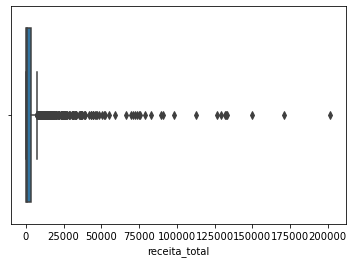

In [16]:
sns.boxplot(x=vendedores['receita_total'])

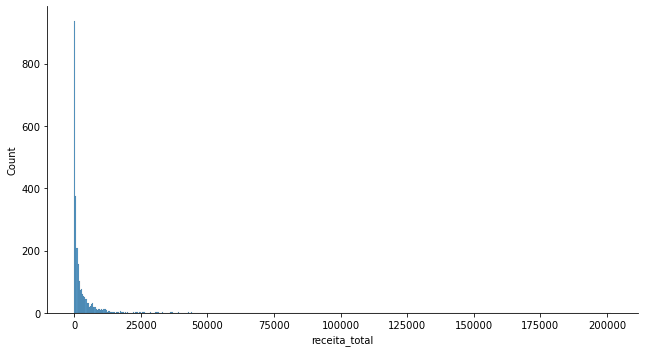

In [17]:
sns.displot(vendedores['receita_total'])
plt.gcf().set_size_inches(10, 5) # alterar tamanho

In [18]:
scaler = RobustScaler()

In [19]:
rfm_data_scaled = scaler.fit_transform(rfm_data[['dias_sem_vender', 'vendas_por_dia', 'receita_total']])

In [20]:
kmeans = KMeans(n_clusters = 3, init='random')

In [99]:
kmeans.fit(rfm_data_scaled)

KMeans(init='random', n_clusters=3)

In [21]:
def implement_kmeans(data, n_clusters, random_state):
    kmeans = KMeans(n_clusters = 3, init='random')
    kmeans.fit(data)
    return kmeans.labels_

In [22]:
dias_sem_vender = rfm_data_scaled[1:]
grupos_dias_sem_vender = implement_kmeans(dias_sem_vender, 3, 1)

vendas_por_dia = rfm_data_scaled[2:]
grupos_vendas_por_dia = implement_kmeans(vendas_por_dia, 3, 1)

receita_total = rfm_data_scaled[3:]
grupos_receita_total = implement_kmeans(receita_total, 3, 1)

In [28]:
df_rfm_scaled = pd.DataFrame(rfm_data_scaled, columns=['dias_sem_vender_R', 'vendas_por_dia_F', 'receita_total_M'])
df_rfm_scaled.index += 1

In [29]:
df_rfm_scaled.head()

,dias_sem_vender_R,vendas_por_dia_F,receita_total_M
1,-0.190909,0.666667,0.127491
2,-0.154545,0.333333,-0.019588
3,-0.136364,-0.111111,-0.010997
4,-0.236364,7.111111,2.295876
5,0.027273,0.222222,0.691753


In [30]:
df_rfm_scaled.isnull().sum()

dias_sem_vender_R    0
vendas_por_dia_F     0
receita_total_M      0
dtype: int64

In [25]:
df_rfm_scaled.shape

(2609, 3)

In [26]:
len(grupos_dias_sem_vender)

2608

In [ ]:
#rfm_data = rfm_data.assign(R = r_labels, F = f_labels, M = m_labels) 
df_rfm_scaled.assign(R=grupos_dias_sem_vender, F=grupos_vendas_por_dia, M=grupos_receita_total)

In [27]:
df_rfm_scaled['grupos_dias_sem_vender'] = grupos_dias_sem_vender
df_rfm_scaled['grupos_vendas_por_dia'] = grupos_vendas_por_dia
df_rfm_scaled['grupos_receita_total'] = grupos_receita_total

ValueError: Length of values (2608) does not match length of index (2609)